In [ ]:
 !pip install pydlm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.5 MB/s eta 0:00:00


In [ ]:
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from pydlm import dlm, trend, seasonality, dynamic
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error

In [89]:
data = pd.read_csv('TM-1.csv')

In [90]:
data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

<ipython-input-90-0ec218d4fe38>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)


,Open,High,Low,Close,Adj Close,Volume
Open,1.0,0.99972,0.99964,0.99937,0.99152,-0.23053
High,0.99972,1.0,0.99955,0.99968,0.99169,-0.22494
Low,0.99964,0.99955,1.0,0.9997,0.99186,-0.23644
Close,0.99937,0.99968,0.9997,1.0,0.99195,-0.22946
Adj Close,0.99152,0.99169,0.99186,0.99195,1.0,-0.27531
Volume,-0.23053,-0.22494,-0.23644,-0.22946,-0.27531,1.0


In [91]:
df = pd.DataFrame(data)

In [92]:
df = df[['Close','High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [111]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [112]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [113]:
from pydlm import dlm, trend, autoReg, dynamic

# Assuming train_data and y_train are already defined

high_feature = []
for price in train_data['High']:
    high_feature.append([price])

# Define the DLM model
myDLM = dlm(y_train)

# Add a linear trend component with prior covariance 1.0
myDLM = myDLM + trend(1, name='lineTrend', w=1.0)

# Add an autoregressive component with a prior covariance of 1e7
myDLM = myDLM + autoReg(degree=1, data=y_train, name='ar1', w=1e7)

# Add a dynamic component with the high_feature
myDLM = myDLM + dynamic(features=high_feature, discount=1, name='High')

# Fit the DLM model
myDLM.fit()

# Print the fitted model
print(myDLM)

/usr/local/lib/python3.10/dist-packages/pydlm/modeler/autoReg.py:75: UserWarning: The data argument in autoReg is deprecated. Please avoid using it.
  warn('The data argument in autoReg is deprecated. Please avoid using it.')


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [114]:
# Quá trình testing, and predict test
x_test= []
for price in test_data['High']:
  x_test.append([price])
print(np.array(x_test).shape)
y_test = np.array(test_data['Close'])
y_test_pred = myDLM.predictN(date = myDLM.n-1, N=len(x_test),featureDict={'High': x_test})
y_test_pred = y_test_pred[0]

(600, 1)


In [115]:
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MAPE:", mape * 100)
print("RMSE:", rmse)

MAE: 8.378634926659148
MAPE: 6.200684275613677
RMSE: 10.75197950360233


In [116]:
#Quá trình validate, and predict val
y_val = np.array(val_data['High'])
x_val= []
for price in val_data['High']:
  x_val.append([price])
print(type(x_val))
size = test_size + val_size
y_pred_val = myDLM.predictN(featureDict={'High': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]
print(y_pred_val)

<class 'list'>
[120.9179148702022, 121.0004044911857, 121.0690189690545, 121.13748029589709, 121.19782498759982, 121.2575972114002, 121.33431216321547, 121.41502919894015, 121.47436012600376, 121.55544306744082, 121.65062838634114, 121.69700475640897, 121.76072599816699, 121.80936554981226, 121.87461348557484, 121.92932462618268, 122.00753242419503, 122.07059759060616, 122.1391224991173, 122.19928920125373, 122.25531482188514, 122.30748631723695, 122.315047325991, 122.33051873189712, 122.42522354990717, 122.51485284979373, 122.60374527675063, 122.66712717757065, 122.73485090834076, 122.79911639477605, 122.87674382096904, 122.96049746265885, 123.0258178074189, 123.11361725703416, 123.2018770210339, 123.26605865389081, 123.32727554278597, 123.38865706349115, 123.4385345677691, 123.5252818710134, 123.60060474989127, 123.67061311290217, 123.73185682967984, 123.7705853469631, 123.87012408298995, 123.94068988911317, 124.00782246767658, 124.07618770542658, 124.17479271273335, 124.237059873627

In [117]:
# Thực hiện dự đoán 30 ngày tiếp theo của feature 'High' dựa trên Linear Regression
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(np.array(train_data.index).reshape(-1,1), train_data['High'])

#Quá trình testing
x_test_LR = np.array(test_data.index).reshape(-1, 1)
y_test_LR = np.array(test_data['High'])
y_pred_LR = LR_model.predict(x_test_LR)

# Quá trình Validate
x_val_LR= np.array(val_data.index).reshape(-1, 1)
y_val_LR = np.array(val_data)
y_pred_val_LR =  LR_model.predict(x_val_LR)

# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

feature_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
feature_next_30_days = LR_model.predict(feature_next_30_days)

print(feature_next_30_days)

[152.91260417 152.93081349 152.94902281 152.96723213 152.98544144
 153.00365076 153.02186008 153.0400694  153.05827871 153.07648803
 153.09469735 153.11290667 153.13111598 153.1493253  153.16753462
 153.18574394 153.20395326 153.22216257 153.24037189 153.25858121
 153.27679053 153.29499984 153.31320916 153.33141848 153.3496278
 153.36783711 153.38604643 153.40425575 153.42246507 153.44067439]


In [118]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x = []
for price in feature_next_30_days:
  x.append([price])
print(type(x))
num_dims = np.ndim(x)
print(num_dims)
y_next_30_days = myDLM.predictN(featureDict={'High': x}, N = 30)
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)

<class 'list'>
2
[120.69087122123936, 120.75856491228926, 120.82495475699338, 120.89133859842708, 120.95772241222008, 121.0241062258858, 121.09049003955094, 121.1568738532161, 121.22325766688124, 121.28964148054638, 121.35602529421152, 121.42240910787667, 121.4887929215418, 121.55517673520694, 121.62156054887208, 121.68794436253724, 121.75432817620238, 121.82071198986752, 121.88709580353266, 121.95347961719779, 122.01986343086294, 122.08624724452808, 122.15263105819322, 122.21901487185836, 122.28539868552352, 122.35178249918866, 122.41816631285378, 122.48455012651893, 122.55093394018407, 122.61731775384922]


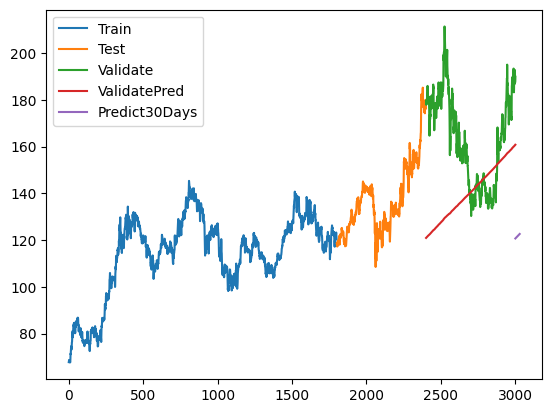

In [119]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index,val_data['Close'])
plt.plot(val_data.index,y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate','ValidatePred','Predict30Days'])
plt.show()